In [19]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import scipy.stats as st
from sklearn.linear_model import LinearRegression
import seaborn as sns
import hvplot.pandas
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

### Read Excel File

In [2]:
df = pd.read_excel('../data/source/USGS_NPWGDv3_excel.xlsx')
df.head()

,IDUSGS,IDORIG,PLAYTYPE,WELLTYPE,BASIN,FORMSIMPLE,TDS,LATITUDE,LONGITUDE,FIPCODE,...,I129,Rn222,Ra226,Ra228,MICROBES,CHARGEBAL,REMARKS,IDDB,SOURCE,REFERENCE
0,1,WE-B3,Shale,Shale Gas,Appalachian,Marcellus,96570.0,40.2354,-79.4704,42129.0,...,NaN,NaN,NaN,NaN,NaN,100.0,Sr from Chapman et al. (2012),PHANMARCELLUS,NaN,"(Phan and others, 2016)"
1,2,WE-B5,Shale,Shale Gas,Appalachian,Marcellus,96570.0,40.2354,-79.4704,42129.0,...,NaN,NaN,NaN,NaN,NaN,100.0,Sr from Chapman et al. (2012),PHANMARCELLUS,NaN,"(Phan and others, 2016)"
2,3,WE-B7,Shale,Shale Gas,Appalachian,Marcellus,96570.0,40.2354,-79.4704,42129.0,...,NaN,NaN,NaN,NaN,NaN,100.0,Sr from Chapman et al. (2012),PHANMARCELLUS,NaN,"(Phan and others, 2016)"
3,4,WE-B9,Shale,Shale Gas,Appalachian,Marcellus,96570.0,40.2354,-79.4704,42129.0,...,NaN,NaN,NaN,NaN,NaN,100.0,Sr from Chapman et al. (2012),PHANMARCELLUS,NaN,"(Phan and others, 2016)"
4,5,WE-B13,Shale,Shale Gas,Appalachian,Marcellus,96570.0,40.2354,-79.4704,42129.0,...,NaN,NaN,NaN,NaN,NaN,100.0,Sr from Chapman et al. (2012),PHANMARCELLUS,NaN,"(Phan and others, 2016)"


## General Cleaning

### Adjust Columns

In [3]:
# List of columns to be removed
columns_to_remove = [
    "IDORIG","FIPCODE","COORDAPX","COORDNEW","STATEFIP","COUNTYFIP","COUNTYORIG","FIELD","FIELDCODE","TOWNRANGE",
    "LOC","OPERATOR","WELLCODE","PERMIT","DATECOMP","ELEVATION","NWIS","GROUP","MEMBER","ERA",
    "EPOCH","LITHOLOGY","POROSITY","TIMESERIES","DAY","DATEANALYS","METHOD","LAB","TEMP_R","PRESSURE","SG",
    "SPGRAV","SPGRAVT","RESIS","RESIST","PHT","EHORP","COND","CONDT","TEMP","TURBIDITY","HEM","MBAS","UNITSORIG",
    "TDSLAB","TDSCALC","TDSDESC","TSS","Ag", "Al", "As", "Au","BO3", "Be", "Bi","Cd", "Co","CO3", "Cr", "Cs", "Cu", "F", 
    "FeIII","FeII","FeS","FeAl","FeAl2O3","Ga","Ge","Hf","Hg","I","Mn","Mo", "N", "NO2", "NO3", "NO3NO2", "NH4", 
    "TKN", "Ni", "OH", "P", "PO4", "Pb", "Rh", "Rb", "S", "SO3", "HS", "Sb","Sc","Se","Si","Sn","Th","Ti","Tl","U","V","W",
    "Y","Zr","La","Ce","Pr","Nd","Sm","Eu","Gd","Tb","Dy","Ho","Er","Tm","Yb","Lu","ACIDITY","ALKALINITY","DIC","DOC","TOC","CYANIDE","BOD",
    "COD","BENZENE","ETHYLBENZ","NAPHTH","PERC","TOLUENE","XYLENE","PHENOLS","ACETATE","BUTYRATE","FORMATE","LACTATE",
    "PROPIONATE","PYRUVATE","VALERATE","ORGACIDS","Ar","CH4","C2H6","CO2","H2","H2S","He","N2","NH3","O2","ALPHA","BETA",
    "dD","H3","d7Li","d11B","d13C","C14","d18O","d34S","d37Cl","K40","d81Br","Sr87Sr86","I129","Rn222","Ra226","Ra228",
    "MICROBES","REMARKS","IDDB","SOURCE","REFERENCE"]

# Remove the specified columns
df_limited_column = df.drop(columns=columns_to_remove, errors='ignore')

# Display the updated merged dataframe
df_limited_column.to_csv('../data/df_output/df_limited_column.csv', index=False)

### Remove Coal, Injection, and Geothermal Play type
### Remove Injection Well Type

In [4]:
df_limited_column=df_limited_column[~df_limited_column['PLAYTYPE'].isin(['Coal', 'Injection','Geothermal'])]
df_limited_column=df_limited_column[~df_limited_column['WELLTYPE'].isin(['Injection'])]

# Display the updated merged dataframe
df_limited_column.to_csv('../data/df_output/df_limited_column_playtype_welltype.csv',index=False)

### Categorize Basins

In [5]:
# Add column "BASIN_CATEGORY" to df_filtered to aid in later filtering

# Define the basin categories
basin_categories = {
    'Anadarko': ['Amarillo Arch', 'Anadarko', 'Anadarko - Chautauqua Platform', 'Anadarko - Southern Oklahoma'],
    'Appalachian': ['Appalachian', 'Black Warrior'],
    'Great Plains':['Wasatch Plateau','Hannah','Wyoming Thrust Belt','Laramie','North Park','Las Animas Arch','Snake River','Sweetgrass Arch','Central Montana Uplift','Great Basin','Raton'],
    'Gulf Coast': ['Arkla', 'Gulf Coast'],
    'Oklahoma Platform': ['Arkoma', 'Arkoma - Chautauqua Platform', 'Central Kansas Uplift', 
                                                'Chautauqua Platform', 'Cherokee', 'Kansas Basins', 'Nemaha Uplift', 
                                                'Sedgwick', 'Southern Oklahoma'],
    'Fort Worth': ['Bend Arch', 'Fort Worth'],
    'Rocky Mountain': ['Big Horn', 'Black Mesa', 'Denver', 'Green River', 'Paradox', 'Piceance', 
                              'Powder River', 'San Juan', 'Uinta', 'Wind River'],
    'Illinois': ['Illinois'],
    'Michigan': ['Michigan'],
    'Permian': ['Palo Duro', 'Permian'],
    'Pacific':['San Joaquin','Sacramento','Los Angeles','Ventura','Cuyama','Santa Maria'],
    'Williston': ['Williston']
}

# Create a reverse mapping from specific basin to category
basin_to_category = {specific: category for category, specifics in basin_categories.items() for specific in specifics}

df_basins_categorized = df_limited_column.copy()

# Map the 'BASIN' column to a new 'BASIN_CATEGORY' column
df_basins_categorized['BASIN_CATEGORY'] = df_basins_categorized['BASIN'].map(basin_to_category)

# Drop rows that don't have a basin category (i.e., not in your list)
df_basins_categorized = df_basins_categorized.dropna(subset=['BASIN_CATEGORY'])

# Save the filtered dataframe to a new CSV file
df_basins_categorized.to_csv('../data/df_output/df_basins_categorized.csv', index=False)

## Technical Cleaning

In [6]:
# Remove rows where TDSUSGS <= 10,000 (to eliminate all produced water with TDS less than brackish water and also the failing analyses)
df_filtered = df_basins_categorized[df_basins_categorized['TDS'] > 10000]

# Save the filtered dataframe to a new CSV file
df_filtered.to_csv('../data/df_filtered_TDS.csv', index=False)

In [7]:
# Fill NaN values in 'KNa', 'K', 'Na' with zeros for calculation
for col in ['KNa', 'K', 'Na']:
    df_filtered[col].fillna(0, inplace=True)

# First, we'll fill NaN values in 'KNa' and 'K' with zeros for the calculation.
df_filtered['KNa'].fillna(0, inplace=True)
df_filtered['K'].fillna(0, inplace=True)

# Apply conditions to calculate 'Na'
# If 'Na' is missing and both 'KNa' and 'K' are present, populate 'Na' with 'KNa' - 'K'
# If 'Na' is missing and 'KNa' is present but 'K' is not, populate 'Na' with 'KNa'

na_mask = df_filtered['Na'].isna()
na_present = df_filtered['Na'] > 0
kna_present = df_filtered['KNa'] > 0
k_present = df_filtered['K'] > 0
k_missing = df_filtered['K'] == 0

df_filtered.loc[k_missing & na_present & kna_present, 'K'] = df_filtered['KNa'] - df_filtered['Na']
df_filtered.loc[na_mask & kna_present & k_present, 'Na'] = df_filtered['KNa'] - df_filtered['K']
df_filtered.loc[na_mask & kna_present & ~k_present, 'Na'] = df_filtered['KNa']

# Remove rows where 'Na' is still missing
df_filtered.dropna(subset=['Na'], inplace=True)

# Save the updated dataframe 
df_filtered.to_csv('../data/df_output/df_filtered_Na.csv', index=False)


C:\Users\darvarir\AppData\Local\Temp\ipykernel_28484\3080712461.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col].fillna(0, inplace=True)
C:\Users\darvarir\AppData\Local\Temp\ipykernel_28484\3080712461.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['KNa'].fillna(0, inplace=True)
C:\Users\darvarir\AppData\Local\Temp\ipykernel_28484\3080712461.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt

In [8]:
# Filter out rows where USGS charge balance is not between -10 and +10
df_filtered = df_filtered[df_filtered['CHARGEBAL'].between(-15, 15)]

# Save the updated dataframe
df_filtered.to_csv('../data/df_output/df_filtered_chargebalance.csv', index=False)

### Remove columns not needed for analysis

In [9]:
columns_to_drop = ['PLAYTYPE', 'WELLTYPE', 'BASIN','KNa','FORMATION']
df_cleaned = df_filtered.drop(columns=[col for col in columns_to_drop if col in df_filtered.columns])

# Save the updated dataframe
df_cleaned.to_csv('../data/df_output/df_cleaned.csv', index=False) 

## Analysis

In [10]:
#Descriptive Statistics of columns with numerical data
descriptive_stats = df_cleaned.describe()
descriptive_stats

,IDUSGS,TDS,LATITUDE,LONGITUDE,DEPTHUPPER,DEPTHLOWER,PH,B,Ba,Br,...,Cl,FeTot,K,Li,Mg,Na,SO4,Sr,Zn,CHARGEBAL
count,60658.000000,60658.000000,60658.000000,60658.000000,47354.000000,40757.000000,45174.000000,2389.000000,8329.000000,4563.000000,...,60658.000000,16003.000000,60658.000000,4131.000000,59996.000000,60658.000000,52153.000000,6122.000000,708.000000,60658.000000
mean,60469.217548,129341.712157,37.097349,-98.777721,6235.401656,6566.729013,6.759097,52.915505,173.602472,784.503260,...,78398.391099,84.432337,377.743706,34.046269,1350.771202,39707.835795,1234.357055,611.628094,18.694839,-0.041724
std,31355.786232,101127.569388,6.455543,6.471952,3216.328922,3220.763496,1.091556,72.357548,829.977487,1115.592047,...,62912.478116,290.154965,1430.226666,74.738829,1760.396632,30587.775012,2006.157375,1009.181036,59.188541,1.683239
min,63.000000,10003.000000,26.022340,-122.251780,3.000000,8.000000,0.051000,0.063100,0.000000,0.100000,...,12.360000,0.030000,0.000000,0.007100,0.060000,0.000000,0.010000,0.089000,0.000100,-15.000000
25%,44719.500000,37612.750000,32.035248,-103.090290,3481.625000,3867.000000,6.150000,12.200000,6.000000,100.850000,...,21188.320000,5.000000,0.000000,4.000000,233.000000,12345.545000,100.000000,70.267500,0.153000,0.000000
50%,63686.500000,105807.000000,35.982000,-98.738730,6029.000000,6430.000000,6.800000,33.500000,23.350000,318.000000,...,64000.000000,22.000000,0.000000,10.000000,826.000000,33627.530000,451.580000,231.700000,1.000000,0.000000
75%,84835.750000,201466.500000,41.689710,-96.270075,8611.750000,8991.000000,7.400000,64.000000,92.000000,1050.000000,...,123849.640000,70.000000,0.000000,34.600000,1938.000000,59314.762500,1576.570000,775.000000,4.000000,0.000000
max,115715.000000,530000.000000,50.095800,-75.611585,24032.000000,23135.000000,12.500000,653.000000,22400.000000,10600.000000,...,555000.000000,10000.000000,75400.000000,1700.000000,46656.000000,189000.000000,150000.000000,29200.000000,575.000000,15.000000


In [11]:
#Descriptive Statistics of only elements of primary interest
specific_columns_stats = df_cleaned[['Li','Na', 'Mg','Ca', 'Cl', 'SO4', 'HCO3']].describe()
specific_columns_stats


,Li,Na,Mg,Ca,Cl,SO4,HCO3
count,4131.000000,60658.000000,59996.000000,60486.000000,60658.000000,52153.000000,54589.000000
mean,34.046269,39707.835795,1350.771202,7867.347937,78398.391099,1234.357055,599.784237
std,74.738829,30587.775012,1760.396632,10644.680610,62912.478116,2006.157375,1336.467575
min,0.007100,0.000000,0.060000,1.000000,12.360000,0.010000,0.010000
25%,4.000000,12345.545000,233.000000,1008.000000,21188.320000,100.000000,113.930000
50%,10.000000,33627.530000,826.000000,3600.000000,64000.000000,451.580000,257.800000
75%,34.600000,59314.762500,1938.000000,11242.750000,123849.640000,1576.570000,610.000000
max,1700.000000,189000.000000,46656.000000,170600.000000,555000.000000,150000.000000,38443.000000


### Clustering Analysis

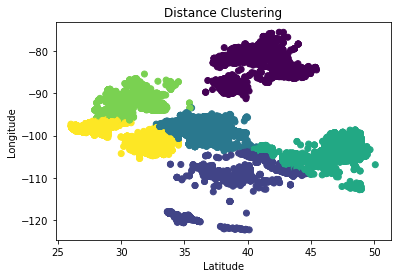

<Figure size 432x288 with 0 Axes>

In [33]:
#Selecting Latitude and Longitude for clustering
X_distance = df_cleaned[['LATITUDE', 'LONGITUDE']].dropna()

# K-Means clustering
kmeans_distance = KMeans(n_clusters=6)
kmeans_distance.fit(X_distance)

# Adding cluster labels to your dataframe
df_cleaned.loc[X_distance.index, 'Distance_Cluster'] = kmeans_distance.labels_

# Plotting the clusters
plt.scatter(df_cleaned['LATITUDE'], df_cleaned['LONGITUDE'], c=df_cleaned['Distance_Cluster'], cmap='viridis')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Distance Clustering')
plt.show()
# Save the plot
plt.savefig('../images/clustering/distance_clustering_plot.png')

# Drop rows where 'LATITUDE' or 'LONGITUDE' is NaN
df_cleaned = df_cleaned.dropna(subset=['LATITUDE', 'LONGITUDE'])

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df_cleaned, geometry=gpd.points_from_xy(df_cleaned['LONGITUDE'], df_cleaned['LATITUDE']))

# Create a base map
map = folium.Map(location=[gdf['LATITUDE'].mean(), gdf['LONGITUDE'].mean()], zoom_start=5)

# Instantiate a marker cluster
marker_cluster = MarkerCluster().add_to(map)

# Add points to the map
for idx, row in gdf.iterrows():
    folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']],
                  popup=f"Cluster: {row['Distance_Cluster']}",
                  icon=folium.Icon(color='blue', icon='info-sign')).add_to(marker_cluster)

# Display the map
map.save('../images/geomaps/distance_cluster_map.html')

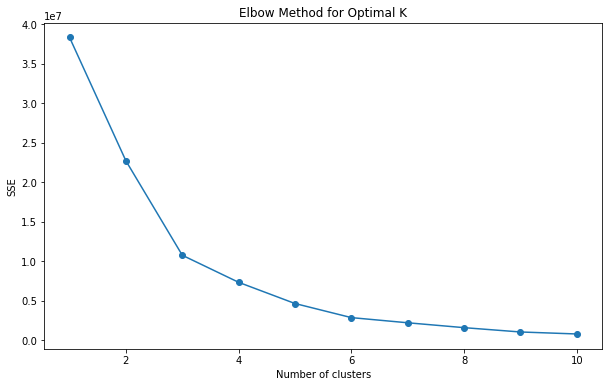

In [13]:
# optimal number of clusters for Li concentration

# Initialize the imputer
imputer = IterativeImputer(RandomForestRegressor(n_estimators=100), max_iter=10, random_state=42)

# Create a flag for known and imputed data
df_cleaned['Data_Type'] = 'Known'
df_cleaned.loc[df_cleaned['Li'].isna(), 'Data_Type'] = 'Imputed'

# Apply the imputation within each basin
for basin in df_cleaned['BASIN_CATEGORY'].unique():
    basin_mask = df_cleaned['BASIN_CATEGORY'] == basin
    df_cleaned.loc[basin_mask, 'Li'] = imputer.fit_transform(df_cleaned.loc[basin_mask, ['Li']])


# Fill NaNs in the 'Li' column with the imputed values
df_cleaned['Li'].fillna(df_cleaned.groupby('BASIN_CATEGORY')['Li'].transform(lambda x: x.fillna(x.mean())), inplace=True)

# Calculate SSE for a range of cluster numbers to find the optimal one
sse = []
for k in range(1, 11): 
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cleaned[['Li']])
    sse.append(kmeans.inertia_) 

# Plot SSE for each *k* to find the elbow
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal K')
plt.show()



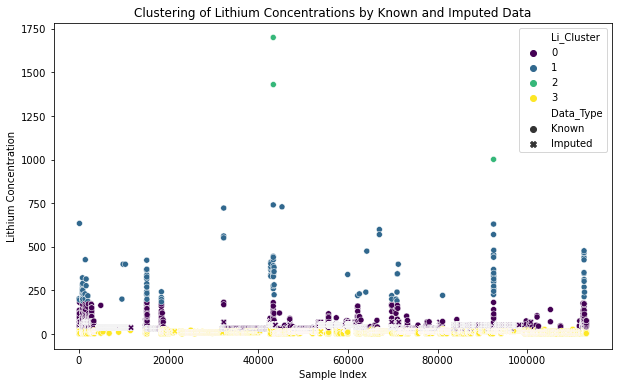

:NdOverlay   [Li_Cluster]
   :Scatter   [index]   (Li,Data_Type)

<Figure size 432x288 with 0 Axes>

In [32]:
# Assuming '4' is the optimal number of clusters determined from the Elbow Method
kmeans_Li = KMeans(n_clusters=4, random_state=42)
df_cleaned['Li_Cluster'] = kmeans_Li.fit_predict(df_cleaned[['Li']])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x=df_cleaned.index, y='Li', hue='Li_Cluster', style='Data_Type', palette='viridis', markers={'Known': 'o', 'Imputed': 'X'})
plt.xlabel('Sample Index')
plt.ylabel('Lithium Concentration')
plt.title('Clustering of Lithium Concentrations by Known and Imputed Data')
plt.legend()
plt.show()
plt.savefig('../images/clustering/Li_clustering_plot1.png') 

# Convert cluster numbers to string for better legend handling
df_cleaned['Li_Cluster'] = df_cleaned['Li_Cluster'].astype(str)

# Define marker styles for known and imputed data
marker_styles = {'Known': 'o', 'Imputed': 'x'}

scatter = df_cleaned.hvplot.scatter(
    x='index',
    y='Li',
    by='Li_Cluster',
    hover_cols=['Li', 'Data_Type'],
    cmap='viridis',
    title='Clustering of Lithium Concentrations by Known and Imputed Data'
)
hvplot.save(scatter, '../images/clustering/Li_clustering_plot2.html')
# Show the plot
scatter


In [23]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_cleaned, geometry=gpd.points_from_xy(df_cleaned['LONGITUDE'], df_cleaned['LATITUDE']))

# Create a Folium map
m = folium.Map(location=[gdf['LATITUDE'].mean(), gdf['LONGITUDE'].mean()], zoom_start=5)

# Define a function to calculate radius based on concentration
def calculate_radius(concentration):
    # Scale the concentration to a reasonable range for radius
    scaled_concentration = (concentration - df_cleaned['Li'].min()) / (df_cleaned['Li'].max() - df_cleaned['Li'].min())
    # Define minimum and maximum radius values
    min_radius = 5
    max_radius = 20
    # Scale the concentration to radius range
    radius = min_radius + (max_radius - min_radius) * scaled_concentration
    return radius

# Add points to the map with different markers for known and imputed data
for idx, row in gdf.iterrows():
    radius = calculate_radius(row['Li'])
    if row['Data_Type'] == 'Known':
        folium.CircleMarker(
            location=(row['LATITUDE'], row['LONGITUDE']),
            radius=radius,
            color='blue',
            fill=True,
            fill_color='blue',
            popup=f'Basin: {row["BASIN_CATEGORY"]}\nLi Concentration: {row["Li"]}',
            ).add_to(m)
    else:
        folium.CircleMarker(
            location=(row['LATITUDE'], row['LONGITUDE']),
            radius=radius,
            color='red',
            fill=True,
            fill_color='red',
            popup=f'Basin: {row["BASIN_CATEGORY"]}\nLi Concentration: {row["Li"]}',
            ).add_to(m)

# Display map
m.save('../images/geomaps/Li_geo_distribution.html')

### Test Hypothesis

In [34]:
#Test Hypothesis: Li Concentration vs TDS
# Check for NaN values and remove them


data = df_cleaned[['Li', 'TDS']].dropna()

# Perform Spearman's rank correlation test
spearman_corr, spearman_pval = st.spearmanr(data['Li'], data['TDS'])

print("Spearman's rank correlation test between Li concentration and TDS:")
print("Correlation Coefficient:", spearman_corr)
print("P-value:", spearman_pval)

# Interpret the results
if spearman_pval < 0.05:
    print("There is a statistically significant relationship between Li concentration and TDS.")
else:
    print("There is no statistically significant relationship between Li concentration and TDS.")


Spearman's rank correlation test between Li concentration and TDS:
Correlation Coefficient: 0.22247959726033864
P-value: 0.0
There is a statistically significant relationship between Li concentration and TDS.


In [25]:
#Test Hypothesis: Li Concentration vs Depth

    
# Check for NaN values and remove them
data = df_cleaned[['Li', 'DEPTHUPPER']].dropna()

# Perform Spearman's rank correlation test
spearman_corr, spearman_pval = st.spearmanr(data['Li'], data['DEPTHUPPER'])

print("Spearman's rank correlation test between Li concentration and Depth:")
print("Correlation Coefficient:", spearman_corr)
print("P-value:", spearman_pval)

# Interpret the results
if spearman_pval < 0.05:
    print("There is a statistically significant relationship between Li concentration and Depth.")
else:
    print("There is no statistically significant relationship between Li concentration and Depth.")

Spearman's rank correlation test between Li concentration and Depth:
Correlation Coefficient: 0.31917420570942784
P-value: 0.0
There is a statistically significant relationship between Li concentration and Depth.


### REGRESSION ANALYSIS

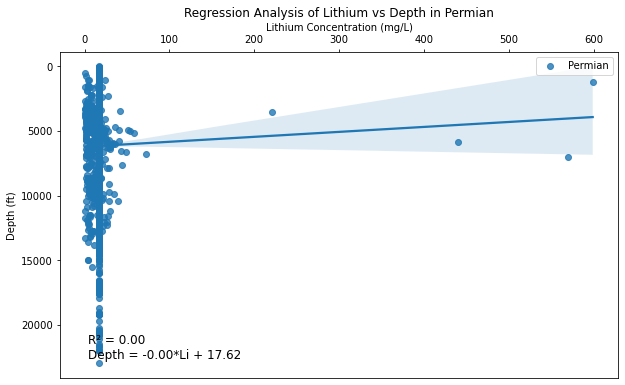

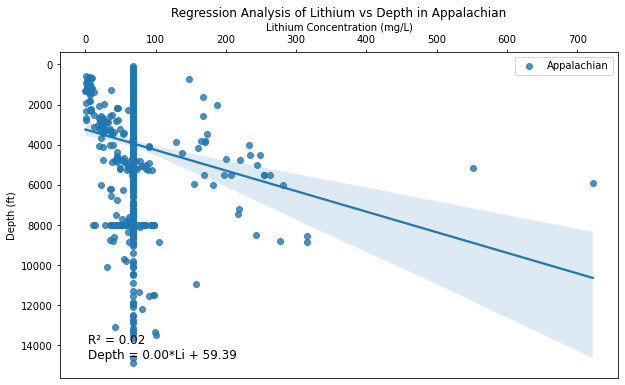

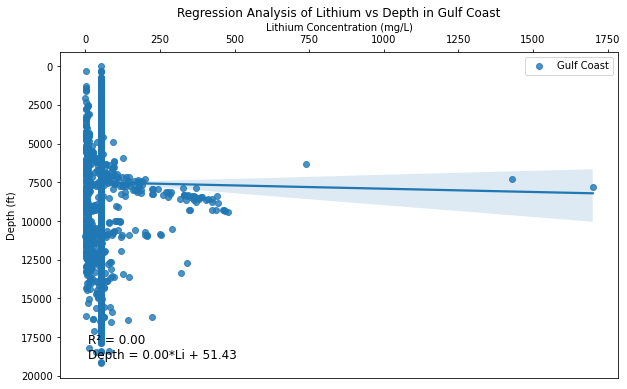

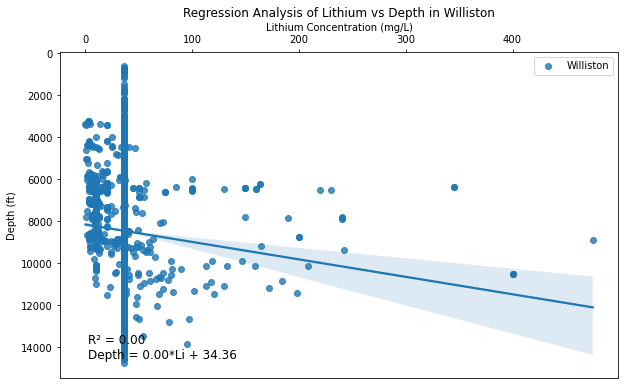

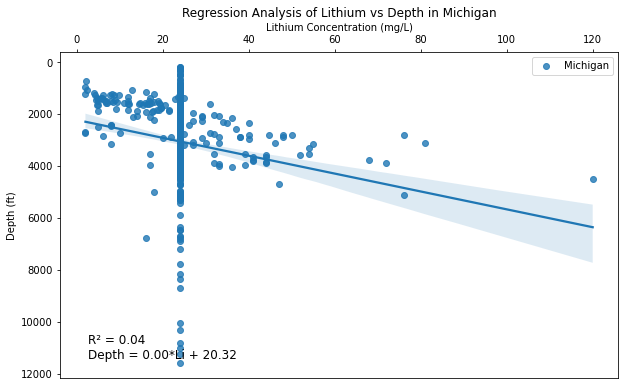

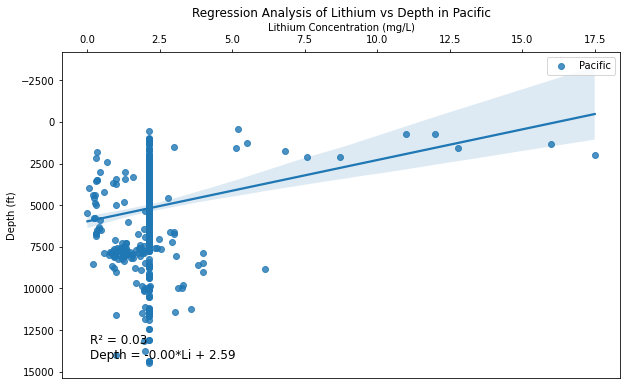

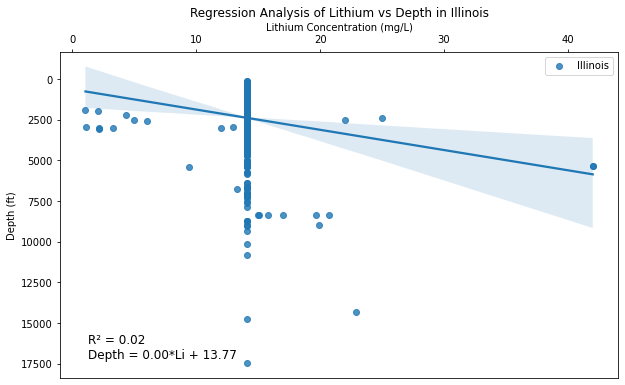

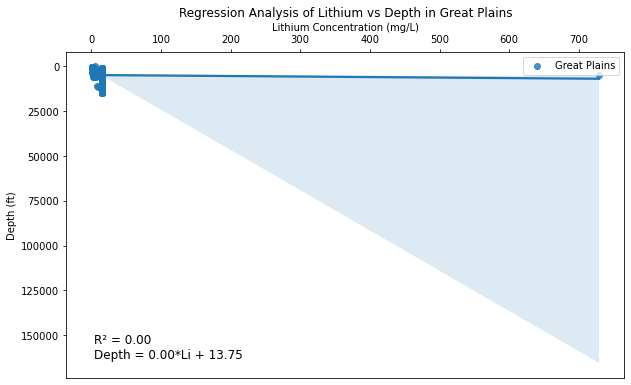

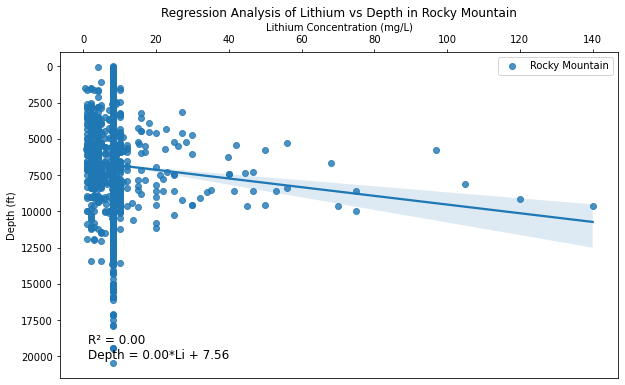

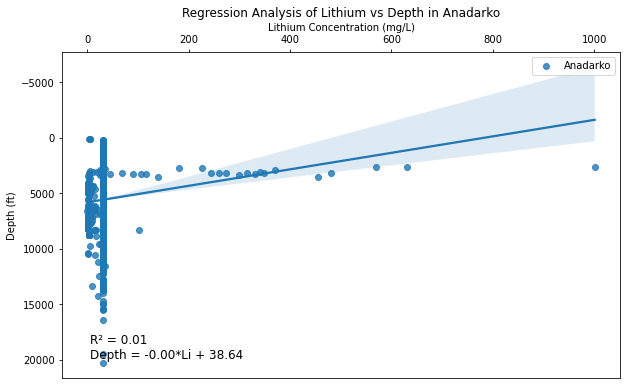

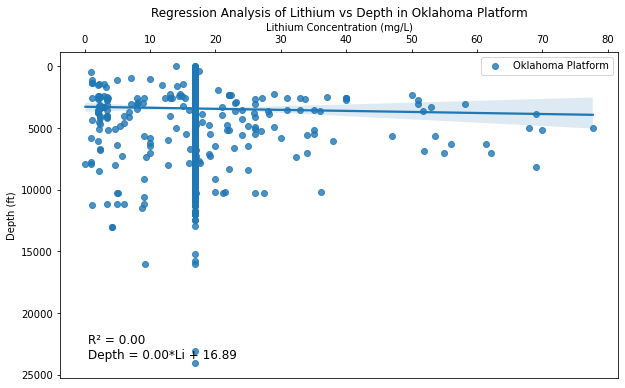

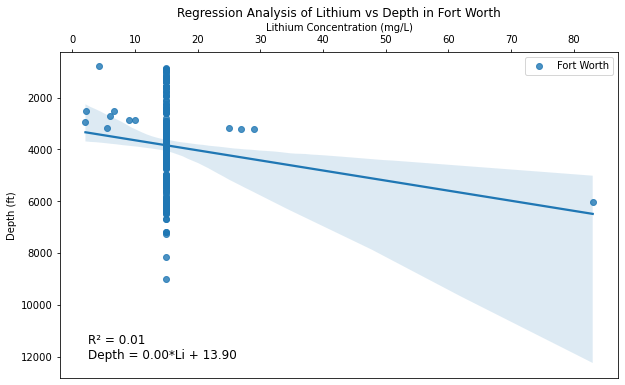

In [35]:
# Selecting only relevant columns
df_analysis = df_cleaned[['Li', 'DEPTHUPPER', 'BASIN_CATEGORY']].dropna()

# Initialize a dictionary to hold regression results
regression_results = {}

# Iterate over each basin category
for basin in df_analysis['BASIN_CATEGORY'].unique():
    # Filter the DataFrame for the current basin
    df_basin = df_analysis[df_analysis['BASIN_CATEGORY'] == basin]

    # Define the predictor (DEPTHUPPER) and response variable (Li)
    X = df_basin[['DEPTHUPPER']]  # Predictor
    y = df_basin['Li']            # Response

    # Create a linear regression model and fit it to the data
    model = LinearRegression()
    model.fit(X, y)

    # Calculate R-squared value
    r_squared = model.score(X, y)
    
    # Store the model and its score in the dictionary
    regression_results[basin] = {
        'model': model,
        'r_squared': model.score(X, y),
        'coefficient': model.coef_,
        'intercept': model.intercept_
    }

    # Plotting the regression for each basin
    plt.figure(figsize=(10, 6))
    sns.regplot(x='Li', y='DEPTHUPPER', data=df_basin, label=f'{basin}')
    plt.xlabel('Lithium Concentration (mg/L)')
    plt.ylabel('Depth (ft)')
    plt.title(f'Regression Analysis of Lithium vs Depth in {basin}')

    # Move x-axis to the top of the plot
    ax = plt.gca()
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.invert_yaxis()  # Invert y-axis for positive depth downward

    # Annotating the plot with R-squared and regression equation
    plt.text(0.05, 0.05, f'R² = {r_squared:.2f}\nDepth = {model.coef_[0]:.2f}*Li + {model.intercept_:.2f}', 
             transform=ax.transAxes, fontsize=12, verticalalignment='bottom')

    plt.legend()
    plt.savefig(f'../images/regression_plots/{basin}_regression_plot.png')
    plt.show()


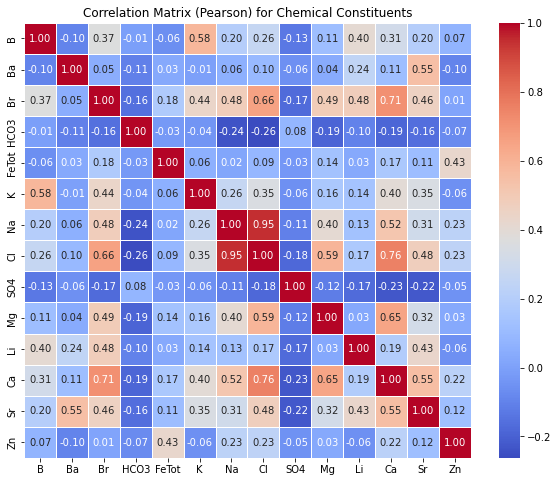

In [36]:
chemicals = ['B','Ba','Br','HCO3','FeTot','K','Na', 'Cl', 'SO4', 'Mg','Li','Ca','Sr','Zn']

# Calculate the correlation matrix using Pearson coefficient
correlation_matrix_pearson = df_cleaned[chemicals].corr(method='pearson')

# Alternatively, for Spearman coefficient
# correlation_matrix_spearman = df_filtered[chemicals].corr(method='spearman')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_pearson, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix (Pearson) for Chemical Constituents')
plt.show()

## PCA

C:\Users\darvarir\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Explained variance by component: [3.02673062e-01 1.09277869e-01 9.59668250e-02 7.40041053e-02
 6.07044284e-02 5.03101415e-02 4.76641769e-02 4.29436812e-02
 3.83029569e-02 3.36534293e-02 2.71313485e-02 2.57757396e-02
 2.25228853e-02 1.95743828e-02 1.76123725e-02 1.34640781e-02
 1.06048649e-02 7.55048245e-03 2.22593643e-04 4.05763855e-05]


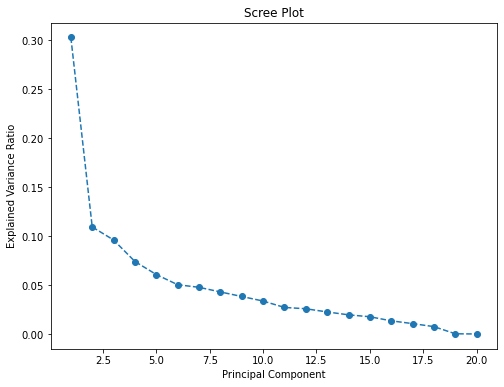

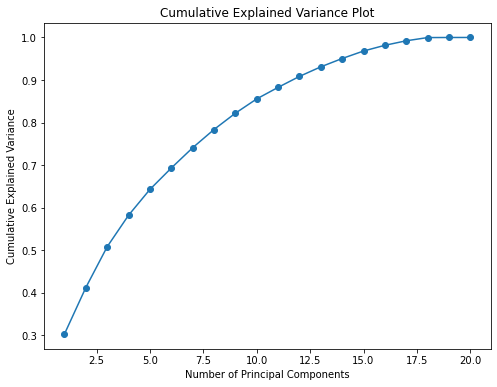

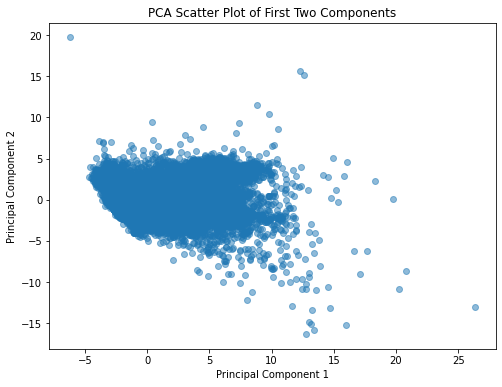

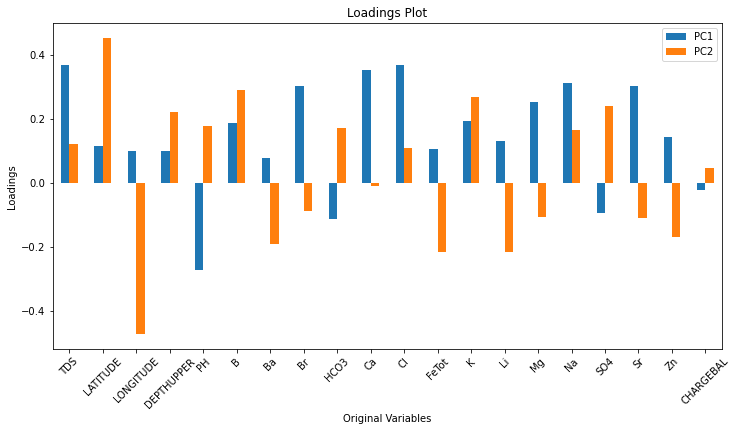

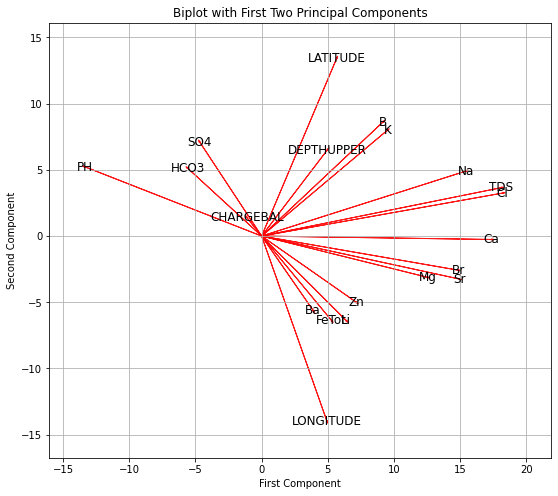

In [37]:
# Define the columns to exclude from the PCA plots
exclude_columns = ['IDUSGS','STATE','COUNTY','PROVINCE','REGION','WELLNAME',
                   'PERIOD','CHARGBAL','DEPTHLOWER','Distance_Cluster']

# Select numerical columns
numerical_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Remove excluded columns
numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

# Prepare the data for imputation
df_impute = df_cleaned[numerical_columns]

# Set up the IterativeImputer
imputer = IterativeImputer(RandomForestRegressor(n_estimators=10), max_iter=10, random_state=0)
df_imputed = imputer.fit_transform(df_impute)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_imputed)

# Initialize PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA results
column_names = [f'PCA{i+1}' for i in range(pca_result.shape[1])]
pca_df = pd.DataFrame(data=pca_result, columns=column_names)


# Display the amount of variance explained by each component
print(f"Explained variance by component: {pca.explained_variance_ratio_}")

# Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

# Save the plot as an image
plt.savefig("../images/pca/PCA_Scree_Plot.png")

# Cumulative Explained Variance Plot
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')

# Save the plot as an image
plt.savefig("../images/pca/Cumulative_Explained_Variance_Plot.png")


pca_two = PCA(n_components=2)
pca_two_result = pca_two.fit_transform(scaled_data)

# PCA Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_two_result[:, 0], pca_two_result[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of First Two Components')
plt.savefig("../images/pca/PCA_Scatter_Plot_First_Two_Components.png")
plt.show()

# Loadings Plot
num_components = pca.n_components_ 
loadings = pca_two.components_.T
loadings_df = pd.DataFrame(data=loadings, columns=['PC1', 'PC2'], index=numerical_columns)

loadings_df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Original Variables')
plt.ylabel('Loadings')
plt.title('Loadings Plot')
plt.xticks(rotation=45)

# Save the plot as an image
plt.savefig("../images/pca/PCA_Loadings_Plot.png")


# Biplot
# Run PCA for the first two components for the biplot
pca_two = PCA(n_components=2)
pca_two_result = pca_two.fit_transform(scaled_data)

# Calculate the rescaled loadings for the first two components
loading_scale_factor = 20  
loadings = pca_two.components_.T * np.sqrt(pca_two.explained_variance_) * loading_scale_factor

# Create the biplot
plt.figure(figsize=(10, 8))

# Plot the loadings (arrows) and variable names
for i in range(loadings.shape[0]):  
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='red', alpha=0.9, width=0.005, head_width=0.1, head_length=0.2)
    plt.text(loadings[i, 0], loadings[i, 1], numerical_columns[i], color='black', ha='center', va='center', fontsize=12)

# Set the aspect of the plot to be equal
plt.gca().set_aspect('equal', adjustable='box')

# Adjust the plot limits based on the loadings for the first two components
plt.xlim(min(loadings[:, 0]) * 1.2, max(loadings[:, 0]) * 1.2)
plt.ylim(min(loadings[:, 1]) * 1.2, max(loadings[:, 1]) * 1.2)

plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('Biplot with First Two Principal Components')
plt.grid()

# Save the plot as an image
plt.savefig("../images/pca/PCA_Biplot_Scaled.png")
plt.show()